# %% Imports

In [586]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
import joblib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility

In [587]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# %% CONFIG

In [588]:
CSV_PATH = 'filtered_readings.csv'
OUTPUT_DIR = 'model_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)


SEQUENCE_LENGTH = 30 # 30-50 recommended
PREDICT_HORIZON = 1 # predict 1 step ahead
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 5e-4
PATIENCE = 10
HIDDEN_UNITS = 64
DROPOUT = 0.2
RECURRENT_DROPOUT = 0.1
USE_BIDIRECTIONAL_AUTO = True # will train and compare both LSTM and BiLSTM
SMOOTH_WINDOW = 3
LAMBDA_SMOOTH = 1e-4
BRIX_READY_THRESHOLD = 0.04

# %% Utilities: Loading & Preprocessing

In [589]:
def load_and_order(csv_path):
    df = pd.read_csv(csv_path)
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)
    return df

In [590]:
def handle_missing(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'timestamp' in df.columns:
        df.set_index('timestamp', inplace=True)
        df[numeric_cols] = df[numeric_cols].interpolate(method='time')
        df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
        df.reset_index(inplace=True)
    else:
        df[numeric_cols] = df[numeric_cols].interpolate().fillna(method='ffill').fillna(method='bfill')
    return df

In [591]:
def remove_outliers_iqr(df, col, k=1.5):
    series = df[col]
    baseline = series.rolling(window=max(3, SEQUENCE_LENGTH//2), center=True, min_periods=1).median()
    resid = (series - baseline).abs()
    q1 = resid.quantile(0.25)
    q3 = resid.quantile(0.75)
    iqr = q3 - q1
    threshold = q3 + k * iqr
    mask = resid > threshold
    series_clean = series.copy()
    series_clean[mask] = baseline[mask]
    df[col] = series_clean
    return df

In [592]:
def remove_outliers_all(df):
    for col in ['gravity','brix','temperature']:
        if col in df.columns:
            df = remove_outliers_iqr(df, col)
    return df

In [593]:
def split_continuous_runs(df):
    if 'batch_id' in df.columns:
        runs = [g.sort_values('timestamp').reset_index(drop=True) for _, g in df.groupby('batch_id', sort=False)]
        runs = [r for r in runs if len(r) >= SEQUENCE_LENGTH]
        return runs
    # fallback: detect large gaps
    if 'interval_seconds' in df.columns:
        gap = df['interval_seconds']
        median = gap.median()
        threshold = max(10 * median, median + 60)
        indices = df.index[gap > threshold].tolist()
    elif 'timestamp' in df.columns:
        diffs = df['timestamp'].diff().dt.total_seconds().fillna(0)
        median = diffs[diffs>0].median() if (diffs>0).any() else 0
        threshold = max(10 * median, median + 60)
        indices = df.index[diffs > threshold].tolist()
    else:
        return [df]
    runs = []
    start = 0
    for idx in indices:
        runs.append(df.iloc[start:idx].reset_index(drop=True))
        start = idx
    runs.append(df.iloc[start:].reset_index(drop=True))
    runs = [r for r in runs if len(r) >= SEQUENCE_LENGTH]
    return runs

In [594]:
def build_sequences_from_runs(runs, seq_len=SEQUENCE_LENGTH, horizon=PREDICT_HORIZON):
    X_list, y_list = [], []
    for run in runs:
        if not set(['gravity','brix','temperature']).issubset(run.columns):
            continue
        values = run[['gravity','brix','temperature']].values
        brix_vals = run['brix'].values
        n = len(run)
        for i in range(0, n - seq_len - horizon + 1):
            X_list.append(values[i:i+seq_len])
            y_list.append(brix_vals[i+seq_len+horizon-1])
    X = np.array(X_list)
    y = np.array(y_list).reshape(-1,1)
    return X, y

# %% Load and preprocess

In [595]:
print('Loading...', CSV_PATH)
df = load_and_order(CSV_PATH)
print('Rows:', len(df))
print('Handling missing...')
df = handle_missing(df)
print('Removing outliers...')
df = remove_outliers_all(df)

Loading... filtered_readings.csv
Rows: 846
Handling missing...
Removing outliers...


C:\Users\Miggy\AppData\Local\Temp\ipykernel_28680\351927595.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')


In [597]:
print('Splitting continuous runs...')
runs = split_continuous_runs(df)
print('Detected runs:', len(runs))

Splitting continuous runs...
Detected runs: 1


# %% Build sequences

In [598]:
X, y = build_sequences_from_runs(runs)
print('Total sequences:', X.shape[0])
if X.shape[0] == 0:
    raise RuntimeError('No sequences produced. Check SEQUENCE_LENGTH and your data segmentation.')

Total sequences: 816


# %% Temporal split (80/20) without shuffling

In [599]:
df['is_fermented'] = (df['brix'] <= 0.04).astype(int)
df = df.sort_values('timestamp').reset_index(drop=True)

# Split the dataframe to ensure both fermented and unfermented are represented
fermented_df = df[df['is_fermented'] == 1]
unfermented_df = df[df['is_fermented'] == 0]

train_fermented = fermented_df.iloc[:int(len(fermented_df)*0.8)]
test_fermented = fermented_df.iloc[int(len(fermented_df)*0.8):]

train_unfermented = unfermented_df.iloc[:int(len(unfermented_df)*0.8)]
test_unfermented = unfermented_df.iloc[int(len(unfermented_df)*0.8):]

train_df = pd.concat([train_fermented, train_unfermented]).sort_values('timestamp').reset_index(drop=True)
test_df = pd.concat([test_fermented, test_unfermented]).sort_values('timestamp').reset_index(drop=True)

print('Training set Brix range:', train_df['brix'].min(), 'to', train_df['brix'].max())
print('Testing set Brix range:', test_df['brix'].min(), 'to', test_df['brix'].max())
print('Training fermented ratio:', train_df['is_fermented'].mean())
print('Testing fermented ratio:', test_df['is_fermented'].mean())

train_runs = split_continuous_runs(train_df)
test_runs = split_continuous_runs(test_df)

X_train, y_train = build_sequences_from_runs(train_runs)
X_test, y_test = build_sequences_from_runs(test_runs)

print('Train sequences:', X_train.shape[0], 'Test sequences:', X_test.shape[0])

Training set Brix range: -0.4838349099167089 to 3.6117096600078185
Testing set Brix range: -0.2936410659307285 to 1.424770229052001
Training fermented ratio: 0.5502958579881657
Testing fermented ratio: 0.5529411764705883
Train sequences: 646 Test sequences: 140


# %% Scaling (fit scalers only on train to prevent leakage)

In [600]:
feature_scalers = {}
for i, col in enumerate(['gravity','brix','temperature']):
    scaler = MinMaxScaler()
    data_to_fit = X_train[:,:,i].reshape(-1,1)
    scaler.fit(data_to_fit)
    X_train[:, :, i] = scaler.transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train[:, :, i].shape)
    X_test[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test[:, :, i].shape)
    feature_scalers[col] = scaler


brix_scaler = MinMaxScaler()
brix_scaler.fit(y_train)
y_train_s = brix_scaler.transform(y_train)
y_test_s = brix_scaler.transform(y_test)

# Save scalers

In [601]:
joblib.dump(feature_scalers, os.path.join(OUTPUT_DIR, 'feature_scalers.joblib'))
joblib.dump(brix_scaler, os.path.join(OUTPUT_DIR, 'brix_scaler.joblib'))
print('Saved scalers.')

Saved scalers.


# %% Smoothness loss (operates on scaled predictions)

In [602]:
import tensorflow.keras.backend as K

In [603]:
def smoothness_loss_lambda(lambda_smooth=LAMBDA_SMOOTH):
    def loss_fn(y_true, y_pred):
        mse = K.mean(K.square(y_true - y_pred))
        diff = y_pred[1:, :] - y_pred[:-1, :]
        def smooth_term(): return K.mean(K.square(diff))
        def zero_term(): return K.constant(0.0, dtype=K.floatx())
        smooth = tf.cond(tf.greater(tf.shape(diff)[0], 0), smooth_term, zero_term)
        return mse + K.cast(lambda_smooth, K.floatx()) * smooth
    return loss_fn

# %% Model builder (single-output regression)

In [604]:
def build_regression_model(input_shape, hidden_units=HIDDEN_UNITS, bidirectional=False):
    inp = Input(shape=input_shape)
    if bidirectional:
        x = Bidirectional(LSTM(hidden_units, return_sequences=False, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT))(inp)
    else:
        x = LSTM(hidden_units, return_sequences=False, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT)(inp)
    x = Dropout(DROPOUT)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,clipnorm=1.0),
                  loss=smoothness_loss_lambda(LAMBDA_SMOOTH),
                  metrics=['mse', 'mae'])
    return model

In [605]:
print("Check for NaN/inf in training and validation data:")
print("X_train:", np.isnan(X_train).sum(), np.isinf(X_train).sum())
print("y_train_s:", np.isnan(y_train_s).sum(), np.isinf(y_train_s).sum())
print("X_test:", np.isnan(X_test).sum(), np.isinf(X_test).sum())
print("y_test_s:", np.isnan(y_test_s).sum(), np.isinf(y_test_s).sum())

Check for NaN/inf in training and validation data:
X_train: 0 0
y_train_s: 0 0
X_test: 0 0
y_test_s: 0 0


# %% Train both LSTM and BiLSTM (if requested)

In [606]:
models_trained = {}
for bidir in ([False, True] if USE_BIDIRECTIONAL_AUTO else [False]):
    name = 'BiLSTM' if bidir else 'LSTM'
    print('Training model:', name)
    model = build_regression_model((X_train.shape[1], X_train.shape[2]), bidirectional=bidir)
    model.summary()
    ckpt = os.path.join(OUTPUT_DIR, f'tuba_model_best_{name}.h5')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=1)
]
    
history = model.fit(X_train, y_train_s,
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    verbose=2)

# evaluate on test set
evals = model.evaluate(X_test, y_test_s, verbose=0)
models_trained[name] = {'model': model, 'history': history, 'evals': evals, 'ckpt': ckpt}

Training model: LSTM


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Training model: BiLSTM


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_37                │ (None, 128)            │        34,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,977 (152.25 KB)

 Trainable params: 38,977 (152.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00059, saving model to model_output\tuba_model_best_BiLSTM.h5

Epoch 1: val_loss improved from inf to 0.00059, saving model to model_output\tuba_model_best_BiLSTM.h5


19/19 - 7s - 389ms/step - loss: 0.0319 - mae: 0.1309 - mse: 0.0319 - val_loss: 5.9084e-04 - val_mae: 0.0227 - val_mse: 5.9084e-04
Epoch 2/100
Epoch 2/100

Epoch 2: val_loss did not improve from 0.00059
19/19 - 0s - 19ms/step - loss: 0.0177 - mae: 0.0887 - mse: 0.0177 - val_loss: 8.9302e-04 - val_mae: 0.0289 - val_mse: 8.9302e-04
Epoch 3/100

Epoch 2: val_loss did not improve from 0.00059
19/19 - 0s - 19ms/step - loss: 0.0177 - mae: 0.0887 - mse: 0.0177 - val_loss: 8.9302e-04 - val_mae: 0.0289 - val_mse: 8.9302e-04
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00059
19/19 - 0s - 18ms/step - loss: 0.0150 - mae: 0.0800 - mse: 0.0150 - val_loss: 6.5752e-04 - val_mae: 0.0236 - val_mse: 6.5752e-04
Epoch 4/100

Epoch 3: val_loss did not improve from 0.00059
19/19 - 0s - 18ms/step - loss: 0.0150 - mae: 0.0800 - mse: 0.0150 - val_loss: 6.5752e-04 - val_mae: 0.0236 - val_mse: 6.5752e-04
Epoch 4/100

Epoch 4: val_loss did not improve from 0.00059
19/19 - 0s - 20ms/step - loss: 0.0143 - ma

# %% Choose best model by minimum val_loss observed

In [607]:
best_name = None
best_val_loss = math.inf
for name, info in models_trained.items():
    hist = info['history'].history
    val_loss_min = min(hist['val_loss']) if 'val_loss' in hist else math.inf
    print(f"Model {name} min val_loss: {val_loss_min}")
    if val_loss_min < best_val_loss:
        best_val_loss = val_loss_min
        best_name = name

print('Best model:', best_name)
best_model = models_trained[best_name]['model']
final_model_path = os.path.join(OUTPUT_DIR, 'tuba_model_final.h5')
best_model.save(final_model_path)
print('Saved final model to', final_model_path)

Model BiLSTM min val_loss: 0.0005908409948460758
Best model: BiLSTM
Saved final model to model_output\tuba_model_final.h5


In [608]:
print('Training samples:', len(X_train), 'Validation samples:', len(X_test))


Training samples: 646 Validation samples: 140


# %% Inference and evaluation

In [609]:
print('Predicting on test set...')
pred_s = best_model.predict(X_test)

Predicting on test set...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


# inverse transform

In [610]:
pred_brix = brix_scaler.inverse_transform(pred_s.reshape(-1,1)).flatten()
true_brix = y_test.flatten()

# Post-process smoothing (rolling)

In [611]:
pred_brix_smoothed = pd.Series(pred_brix).rolling(window=SMOOTH_WINDOW, min_periods=1, center=True).mean().values

# Regression metrics

In [612]:
mse = mean_squared_error(true_brix, pred_brix)
mae = mean_absolute_error(true_brix, pred_brix)
rmse = math.sqrt(mse)
print(f'MSE: {mse:.6f}, MAE: {mae:.6f}, RMSE: {rmse:.6f}')


mse_s = mean_squared_error(true_brix, pred_brix_smoothed)
mae_s = mean_absolute_error(true_brix, pred_brix_smoothed)
rmse_s = math.sqrt(mse_s)
print(f'MSE (smoothed): {mse_s:.6f}, MAE (smoothed): {mae_s:.6f}, RMSE (smoothed): {rmse_s:.6f}')

MSE: 0.087837, MAE: 0.194821, RMSE: 0.296373
MSE (smoothed): 0.087650, MAE (smoothed): 0.194541, RMSE (smoothed): 0.296057


# Volatility metric

In [613]:
def volatility(series):
    return np.mean(np.abs(np.diff(series)))
vol_true = volatility(true_brix)
vol_pred = volatility(pred_brix)
vol_pred_s = volatility(pred_brix_smoothed)
print(f'Volatility (true): {vol_true:.6f}, (pred): {vol_pred:.6f}, (pred smoothed): {vol_pred_s:.6f}')

Volatility (true): 0.030890, (pred): 0.010861, (pred smoothed): 0.010532


# Classification from predicted brix (smoothed)

In [614]:
# --- Classification based on new Brix fermentation threshold ---
FERMENTED_MAX = 0.04   # brix <= 0.04  → fermented
NOT_FERMENTED_MIN = 0.05  # brix > 0.04 → not fermented

true_ready = np.where(true_brix <= FERMENTED_MAX, 1, 0)
pred_ready = np.where(pred_brix_smoothed <= FERMENTED_MAX, 1, 0)

acc = np.mean(pred_ready == true_ready)
print(f'Classification accuracy (from predicted brix): {acc:.4f}')
print('Classification report:')
print(classification_report(true_ready, pred_ready, zero_division=0))

cm = confusion_matrix(true_ready, pred_ready)
print('Confusion matrix:', cm)

# Optional: display counts per class to confirm
print('True Ready counts:', np.unique(true_ready, return_counts=True))
print('Pred Ready counts:', np.unique(pred_ready, return_counts=True))


Classification accuracy (from predicted brix): 0.8357
Classification report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        46
           1       1.00      0.76      0.86        94

    accuracy                           0.84       140
   macro avg       0.83      0.88      0.83       140
weighted avg       0.89      0.84      0.84       140

Confusion matrix: [[46  0]
 [23 71]]
True Ready counts: (array([0, 1]), array([46, 94], dtype=int64))
Pred Ready counts: (array([0, 1]), array([69, 71], dtype=int64))


# %% Plots: training curves and per-run plots

In [615]:
import matplotlib.pyplot as plt


def plot_training(history, model_name):
    hist = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.title(f'{model_name} Combined Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.get('mse', []), label='train_mse')
    plt.plot(hist.get('val_mse', []), label='val_mse')
    plt.title(f'{model_name} MSE')
    plt.legend()
    plt.show()

# show curves

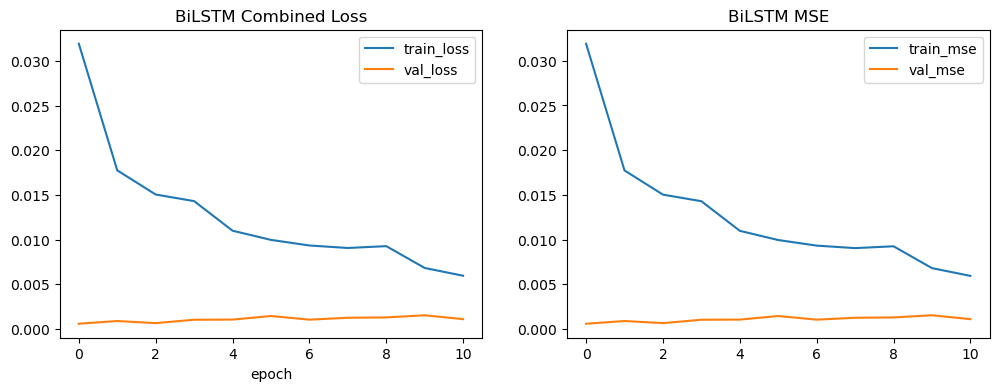

In [616]:
plot_training(models_trained[best_name]['history'], best_name)

# Plot a chunk of test predictions vs actual

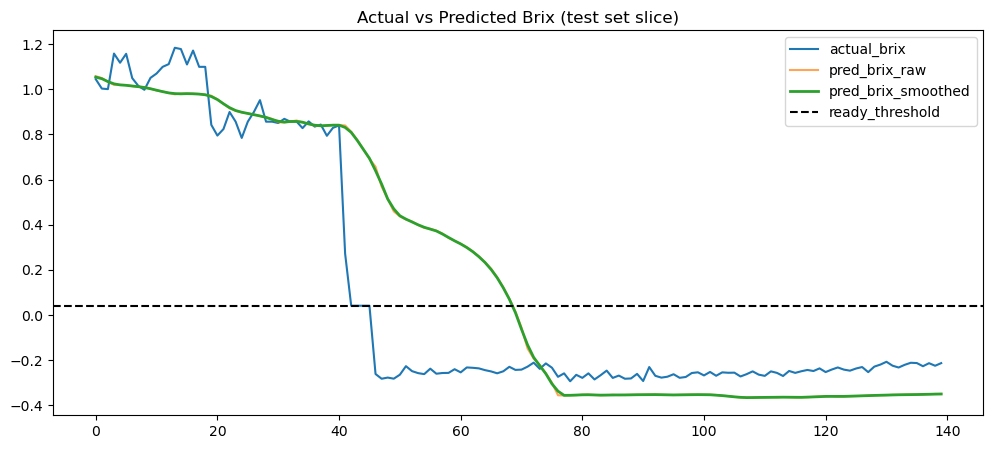

In [617]:
Nplot = min(300, len(pred_brix))
plt.figure(figsize=(12,5))
plt.plot(true_brix[:Nplot], label='actual_brix')
plt.plot(pred_brix[:Nplot], label='pred_brix_raw', alpha=0.7)
plt.plot(pred_brix_smoothed[:Nplot], label='pred_brix_smoothed', linewidth=2)
plt.axhline(BRIX_READY_THRESHOLD, color='k', linestyle='--', label='ready_threshold')
plt.legend()
plt.title('Actual vs Predicted Brix (test set slice)')
plt.show()

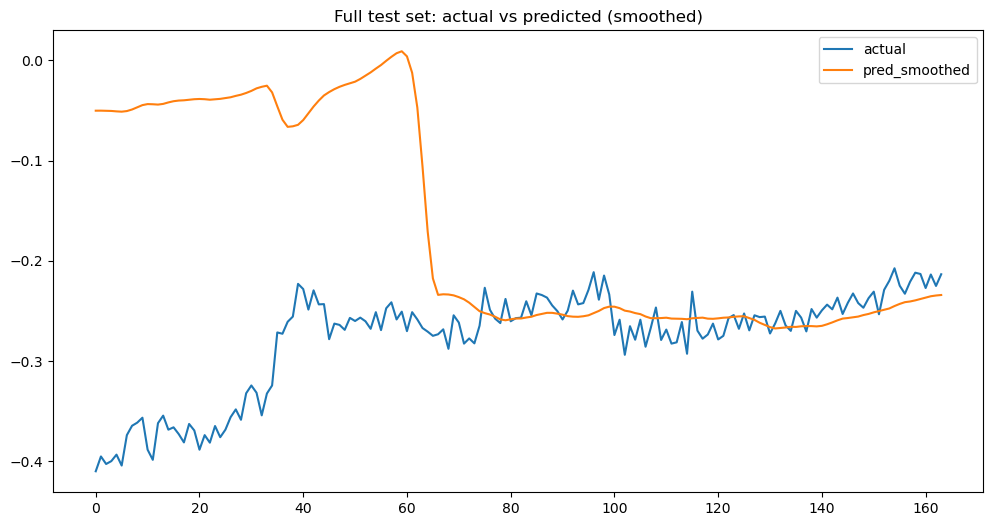

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(true_brix, label='actual')
plt.plot(pred_brix_smoothed, label='pred_smoothed')
plt.title('Full test set: actual vs predicted (smoothed)')
plt.legend()
plt.show()

In [618]:
import numpy as np

print("True Ready counts:", np.unique(true_ready, return_counts=True))
print("Pred Ready counts:", np.unique(pred_ready, return_counts=True))

True Ready counts: (array([0, 1]), array([46, 94], dtype=int64))
Pred Ready counts: (array([0, 1]), array([69, 71], dtype=int64))


In [619]:
print(f"Brix test range: {true_brix.min():.4f} to {true_brix.max():.4f}")
print(f"Predicted Brix range: {pred_brix_smoothed.min():.4f} to {pred_brix_smoothed.max():.4f}")

Brix test range: -0.2936 to 1.1839
Predicted Brix range: -0.3661 to 1.0539


In [620]:
print(df['brix'].describe())

count    846.000000
mean       0.710651
std        1.268617
min       -0.483835
25%       -0.341815
50%       -0.240234
75%        1.628113
max        3.611710
Name: brix, dtype: float64


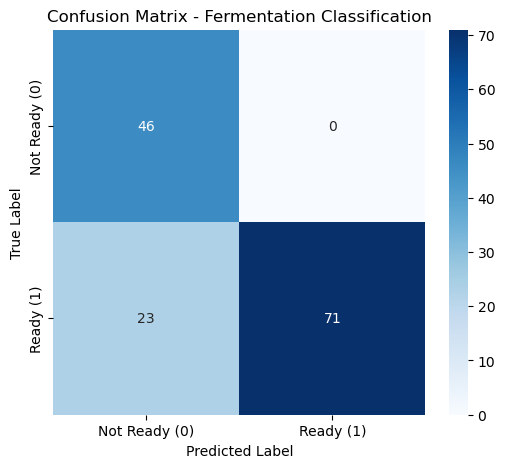

In [622]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix (assuming y_true and y_pred_ready are your true/predicted labels)
cm = confusion_matrix(true_ready, pred_ready)

# Define class labels
labels = ['Not Ready (0)', 'Ready (1)']

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Fermentation Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()